### THỰC HÀNH MHNC LAB 6

### NGUYỄN MINH HOÀNG 18110095

In [33]:
import pandas as pd
import numpy as np
import nltk
import timeit
import io

import tensorflow as tf
from tensorflow.keras.layers import ( Conv1D, GlobalAveragePooling1D,
                              Input, Embedding, LSTM, Bidirectional, 
                               Dense, Dropout, BatchNormalization,GRU)
from tensorflow.keras.models import Model

In [ ]:
#đọc data
df = pd.read_csv("https://raw.githubusercontent.com/huynhthanh98/AML/main/lab-04/spam_detection.csv")
df.head()

,Text,Label,y
0,"Go until jurong point, crazy.. Available only ...",ham,0
1,Ok lar... Joking wif u oni...,ham,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,1
3,U dun say so early hor... U c already then say...,ham,0
4,"Nah I don't think he goes to usf, he lives aro...",ham,0


In [ ]:
df.shape

(5574, 3)

In [ ]:
nltk.download('punkt')
texts = df["Text"].to_list()
texts = [text.lower() for text in texts ]           # chuyển các đoạn text thành chữ thường (word embedding chỉ cho chữ thường)
tokenized_texts = [nltk.tokenize.word_tokenize(text) for text in texts]    # tách câu thành một list các từ
print(tokenized_texts[0])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
['go', 'until', 'jurong', 'point', ',', 'crazy..', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', '...', 'cine', 'there', 'got', 'amore', 'wat', '...']


### 1. Hãy dùng bộ Glove 300d để làm embedding cho model

In [ ]:
#Tải bộ weights Glove
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-11-20 14:44:24--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-11-20 14:44:25--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-11-20 14:44:25--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
#Giải Nén
! unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
## không cần hiểu đống này lắm đâu
def load_word_embeddings(fname):
    import io
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    vocab, matrix = [], []
    i=0
    for line in fin:
        tokens = line.rstrip().split(' ')
        vocab.append(tokens[0])
        matrix.append(list(map(float, tokens[1:])))
    return vocab, np.asarray(matrix) 

In [ ]:
#vocab là bộ từ điển các từ có trong Glove
#matrix chứa các vector biểu diễn các từ 
##Ta chọn bộ weighs có số chiều là 300
vocab, matrix = load_word_embeddings("glove.6B.300d.txt")
print(len(vocab))
print(matrix.shape)

400000
(400000, 300)


In [ ]:


# Tạo một dictionary, có nhiệm vụ là một ánh xạ từ ảnh sang mã số, mã số được bắt đầu từ 2 vì số 0 và 1 được dành cho trường hợp đặc biệt
word_to_index = {word: index+2 for index, word in enumerate(vocab)}

# Do do mã số được bắt đầu từ 2, nên cần thêm 2 vector vào đàu ma trận
embedding_matrix = np.pad(matrix, ((2,0),(0,0)), mode='constant', constant_values =0.0)
print(embedding_matrix)

[[ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.04656    0.21318   -0.0074364 ...  0.0090611 -0.20989    0.053913 ]
 ...
 [ 0.075713  -0.040502   0.18345   ...  0.21838    0.30967    0.43761  ]
 [ 0.81451   -0.36221    0.31186   ...  0.075486   0.28408   -0.17559  ]
 [ 0.429191  -0.296897   0.15011   ...  0.28975    0.32618   -0.0590532]]


In [ ]:
## Bây giờ ta sẽ chuyển data spam dection thành các mã số


## Gán các mã
__PADDED_INDEX__ = 0    # mã dùng cho các vị trí chỉ có tính nối dài cho cùng kích thước
__UNKNOWN_WORD__ = 1    # mã cho những từ không có trong embedding


X = []
for text in tokenized_texts:
    cur_text_indices = []
    for word in text:
        if word in word_to_index:
            cur_text_indices.append(word_to_index[word])    ## map từ word sang index
        else:
            cur_text_indices.append(__UNKNOWN_WORD__)       ## gán unknown cho từ không có trong bộ glove
    X.append(cur_text_indices)

## pad data cho có cùng chiều dài
X = tf.keras.preprocessing.sequence.pad_sequences(sequences=X,       # sequences: list các câu có độ dài không bằng nhau
                                                  padding='post')    # vị trí pad là 'pre' (trước) hoặc 'post' (sau)

y = df['y'].values   ## Label của bài toán, 0 là không phải spam, 1 là spam

In [ ]:
## Chia data
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size= 0.2, random_state =0)

### 2. Hãy tìm hiểu cách dùng của convolution 1D trong keras để train mô hình dưới đây
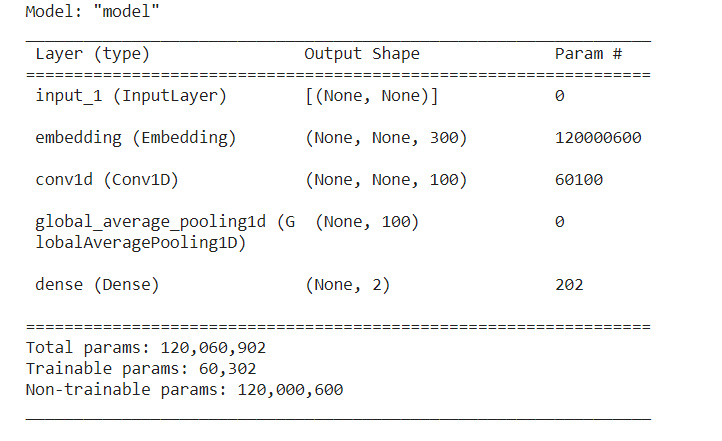

**Conv1D** cũng tượng tự như **Conv2D** nhưng thay vì **Conv2D** sẽ được dùng để cho hình ảnh thì **Conv1D** được dùng để xử lý dữ liệu dạng chuỗi (dữ liệu 1 chiều).

**Trainable = False**

In [61]:
inputs = Input(shape=(None,))                   ## None biểu thị kích thước không xác định của câu

x = Embedding(input_dim=embedding_matrix.shape[0],   ## Khai báo kích thước của vocab
                  output_dim=embedding_matrix.shape[1],   ## Khai báo kích thước của embedding
                  embeddings_initializer = tf.keras.initializers.Constant(value=embedding_matrix),  ## Khởi tạo cho embedding bằng ma trận có sẵn
                  trainable=False,                       ## Không cần thiết train embedding
                  mask_zero=True)(inputs)                 ## zero_mask: những vị trí có giá trị 0 không được tính toán, vì đó là giá trị thêm vào cho đủ độ dài mà thôi
                                                        ##  (__PADDED_INDEX__ gán bằng 0)

x = Conv1D(filters = 100, 
            kernel_size = 2, 
            activation= tf.nn.relu,
            padding = 'valid',
            )(x)
x = GlobalAveragePooling1D()(x)
outputs = Dense(units = 2 , activation = tf.nn.softmax)(x)
model1 = Model(inputs=inputs,
              outputs=outputs)
model1.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_12 (Embedding)    (None, None, 300)         120000600 
                                                                 
 conv1d_12 (Conv1D)          (None, None, 100)         60100     
                                                                 
 global_average_pooling1d_12  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_12 (Dense)            (None, 2)                 202       
                                                                 
Total params: 120,060,902
Trainable params: 60,302
Non-trainable params: 120,000,600
_______________________________________

In [62]:
performances = []
times = []

In [63]:

start = timeit.default_timer() 

model1.compile(
                optimizer = tf.keras.optimizers.Adam(learning_rate= 7e-3, name='RMSprop'),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

history = model1.fit(X_train, y_train,
                    batch_size= 128,
                    epochs= 10,
                    )  

stop = timeit.default_timer()
print('Time: ', stop - start) 

Epoch 1/10
35/35 [==============================] - 1s 12ms/step - loss: 0.3808 - accuracy: 0.8569
Epoch 2/10
35/35 [==============================] - 0s 12ms/step - loss: 0.1212 - accuracy: 0.9617
Epoch 3/10
35/35 [==============================] - 0s 12ms/step - loss: 0.0883 - accuracy: 0.9711
Epoch 4/10
35/35 [==============================] - 0s 12ms/step - loss: 0.0677 - accuracy: 0.9785
Epoch 5/10
35/35 [==============================] - 0s 12ms/step - loss: 0.0591 - accuracy: 0.9812
Epoch 6/10
35/35 [==============================] - 0s 12ms/step - loss: 0.0484 - accuracy: 0.9852
Epoch 7/10
35/35 [==============================] - 0s 12ms/step - loss: 0.0417 - accuracy: 0.9886
Epoch 8/10
35/35 [==============================] - 0s 12ms/step - loss: 0.0377 - accuracy: 0.9890
Epoch 9/10
35/35 [==============================] - 0s 12ms/step - loss: 0.0322 - accuracy: 0.9919
Epoch 10/10
35/35 [==============================] - 0s 12ms/step - loss: 0.0273 - accuracy: 0.9926
Time:  5.

In [64]:
result = model1.evaluate(X_valid,y_valid)
print("loss và accuracy trên tập val là {} {}".format(result[0],result[1]))

35/35 [==============================] - 0s 4ms/step - loss: 0.0610 - accuracy: 0.9821
loss và accuracy trên tập val là 0.0610235370695591 0.9820627570152283


In [65]:
times.append(stop-start)
performances.append(result[1])

### 3.Xét 2 trường hợp trainable là True và False trong lớp embedding và đưa ra so sánh

    Lưu ý: Dùng data của bài thực hành số 5 để train

**Trainable = True**

In [66]:


inputs = Input(shape=(None,))                   ## None biểu thị kích thước không xác định của câu

x = Embedding(input_dim=embedding_matrix.shape[0],   ## Khai báo kích thước của vocab
                  output_dim=embedding_matrix.shape[1],   ## Khai báo kích thước của embedding
                  embeddings_initializer = tf.keras.initializers.Constant(value=embedding_matrix),  ## Khởi tạo cho embedding bằng ma trận có sẵn
                  trainable=True,                       ## Không cần thiết train embedding
                  mask_zero=True)(inputs)                 ## zero_mask: những vị trí có giá trị 0 không được tính toán, vì đó là giá trị thêm vào cho đủ độ dài mà thôi
                                                        ##  (__PADDED_INDEX__ gán bằng 0)

x = Conv1D(filters = 100, 
            kernel_size = 2, 
            activation= tf.nn.relu,
            padding = 'valid',
            )(x)
x = GlobalAveragePooling1D()(x)
outputs = Dense(units = 2 , activation = tf.nn.softmax)(x)
model2 = Model(inputs=inputs,
              outputs=outputs)
model2.summary()


Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_13 (Embedding)    (None, None, 300)         120000600 
                                                                 
 conv1d_13 (Conv1D)          (None, None, 100)         60100     
                                                                 
 global_average_pooling1d_13  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_13 (Dense)            (None, 2)                 202       
                                                                 
Total params: 120,060,902
Trainable params: 120,060,902
Non-trainable params: 0
____________________________________________

In [67]:
start = timeit.default_timer() 
model2.compile(
                optimizer = tf.keras.optimizers.RMSprop(learning_rate= 3e-3, name='RMSprop'),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
history = model2.fit(X_train, y_train,
                    batch_size= 128,
                    epochs= 10) 

stop = timeit.default_timer()
print('Time: ', stop - start)

Epoch 1/10
35/35 [==============================] - 2s 45ms/step - loss: 0.2432 - accuracy: 0.8966
Epoch 2/10
35/35 [==============================] - 1s 42ms/step - loss: 0.0663 - accuracy: 0.9785
Epoch 3/10
35/35 [==============================] - 1s 42ms/step - loss: 0.0448 - accuracy: 0.9865
Epoch 4/10
35/35 [==============================] - 1s 42ms/step - loss: 0.0327 - accuracy: 0.9901
Epoch 5/10
35/35 [==============================] - 1s 42ms/step - loss: 0.0256 - accuracy: 0.9928
Epoch 6/10
35/35 [==============================] - 1s 42ms/step - loss: 0.0190 - accuracy: 0.9944
Epoch 7/10
35/35 [==============================] - 1s 43ms/step - loss: 0.0140 - accuracy: 0.9962
Epoch 8/10
35/35 [==============================] - 1s 42ms/step - loss: 0.0095 - accuracy: 0.9975
Epoch 9/10
35/35 [==============================] - 1s 42ms/step - loss: 0.0086 - accuracy: 0.9978
Epoch 10/10
35/35 [==============================] - 1s 42ms/step - loss: 0.0073 - accuracy: 0.9982
Time:  21

In [68]:
result = model2.evaluate(X_valid,y_valid)
print("loss và accuracy trên tập val là {} {}".format(result[0],result[1]))

35/35 [==============================] - 0s 4ms/step - loss: 0.0626 - accuracy: 0.9857
loss và accuracy trên tập val là 0.06261223554611206 0.9856502413749695


In [69]:
times.append(stop-start)
performances.append(result[1])

In [75]:
import pandas as pd
  
# initialize list of lists
data = {
  "Times": times,
  "Accuracy": performances
}
  
# Create the pandas DataFrame
df = pd.DataFrame(data, index =['Trainable = False',
                                'Trainable = True'])
df  

,Times,Accuracy
Trainable = False,5.653474,0.982063
Trainable = True,21.132389,0.985650


So sánh giữa 2 trường hợp **Trainable = True** và **Trainable = False**, ta thấy rằng đối với **Trainable = True** thì **accuracy** của phương pháp này ra cao hơn so với **Trainable = False**, tuy nhiên lượng thời gian để chạy phương pháp này là khá lâu (21s so với 5s của **Trainable = False**) do ta phải cập nhật lại các bộ tham số mới sau mỗi epoch. Do vậy đối với data này , nếu ta ưu tiên kết quả hơn thì **Trainable = True** sẽ hữu dụng hơn còn nếu ta quan tâm về thời gian chạy thì sẽ chọn phương pháp còn lại.